In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import cv2
import sklearn

In [5]:
data=r'D:\WebApp_BrainTumorDetection\archive\brain_tumor_dataset\dataimg'
no=r'D:\WebApp_BrainTumorDetection\archive\no'
yes=r'D:\WebApp_BrainTumorDetection\archive\yes'


In [6]:
dirlist=[no,yes]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [7]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,D:\WebApp_BrainTumorDetection\archive\no\1 no....,No
1,D:\WebApp_BrainTumorDetection\archive\no\10 no...,No
2,D:\WebApp_BrainTumorDetection\archive\no\11 no...,No
3,D:\WebApp_BrainTumorDetection\archive\no\12 no...,No
4,D:\WebApp_BrainTumorDetection\archive\no\13 no...,No


In [8]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


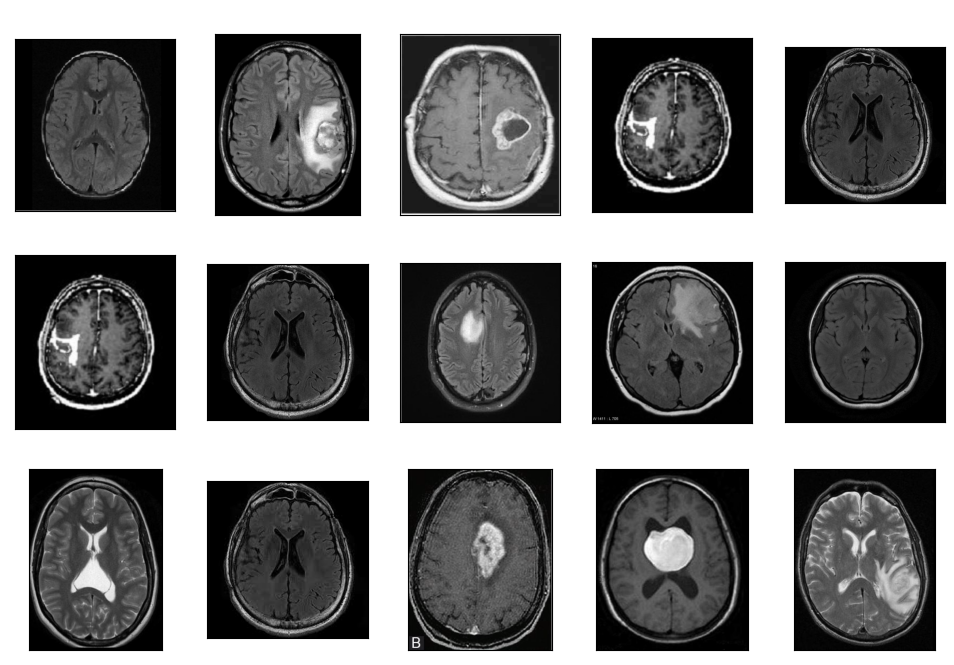

In [9]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [12]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [13]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [14]:
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)


base_model.trainable = False


inputs = keras.Input(shape=(224, 224, 3))


x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_____________________________________________

In [15]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0)
]





model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate= 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 100, 
                    callbacks = [callbacks], verbose = 1)
                    

Epoch 1/100
7/7 [==============================] - 20s 2s/step - loss: 0.9128 - accuracy: 0.6111 - val_loss: 1.1837 - val_accuracy: 0.5000
Epoch 2/100
7/7 [==============================] - 11s 2s/step - loss: 0.8393 - accuracy: 0.6111 - val_loss: 1.0443 - val_accuracy: 0.5000
Epoch 3/100
7/7 [==============================] - 11s 2s/step - loss: 0.8260 - accuracy: 0.5926 - val_loss: 0.9746 - val_accuracy: 0.5000
Epoch 4/100
7/7 [==============================] - 11s 2s/step - loss: 0.7361 - accuracy: 0.6111 - val_loss: 0.9337 - val_accuracy: 0.5417
Epoch 5/100
7/7 [==============================] - 12s 2s/step - loss: 0.7009 - accuracy: 0.6204 - val_loss: 0.8021 - val_accuracy: 0.4583
Epoch 6/100
7/7 [==============================] - 12s 2s/step - loss: 0.6859 - accuracy: 0.5880 - val_loss: 0.7207 - val_accuracy: 0.5833
Epoch 7/100
7/7 [==============================] - 13s 2s/step - loss: 0.7389 - accuracy: 0.5880 - val_loss: 0.7683 - val_accuracy: 0.5417
Epoch 8/100
7/7 [==========

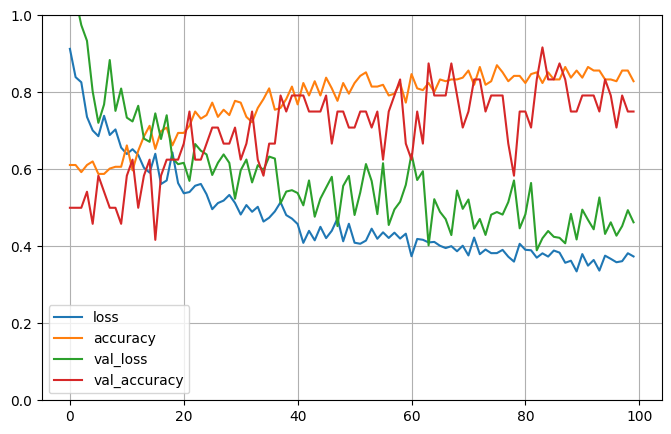

In [16]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()